In [1]:
from scripts import mapcalc, get_user_POIs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder

In [3]:
%matplotlib inline

In [4]:
arrests = pd.read_csv('clean_data/arrests_GIS.csv')
schools = pd.read_csv('clean_data/school_list_GIS.csv')
restaurants = pd.read_csv('clean_data/restaurant_list_GIS.csv')
groceries = pd.read_csv('clean_data/grocerystore_list_GIS.csv')
vacancies = pd.read_csv('clean_data/vacancies_GIS.csv')

# Add my own point of interest (JHU Homewood campus, where I work...)
JHU = get_user_POIs.add_user_POI('3400 N Charles St, Baltimore, MD')

In [5]:
# compute histograms of arrests and vacant buildings by location
arrest_heat = mapcalc.hist2d_bmoredata(arrests, 0, 0)
vacancy_heat = mapcalc.hist2d_bmoredata(vacancies, 0, 0)

# compute 2D grids of distances to nearest point of interest
restaurant_heat = mapcalc.compute_distances_to_POIs(restaurants)
grocery_heat = mapcalc.compute_distances_to_POIs(groceries[groceries['type'] == 'Full Supermarket'])

# compute 2D grid of distance to Johns Hopkins Homewood campus
JHU_heat = mapcalc.compute_distances_to_POIs(JHU)

/Users/wallacdc/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


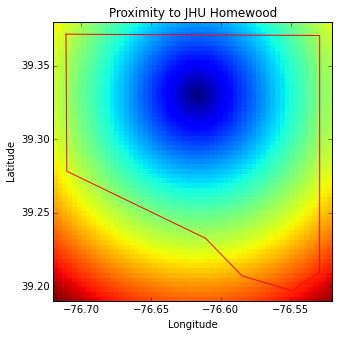

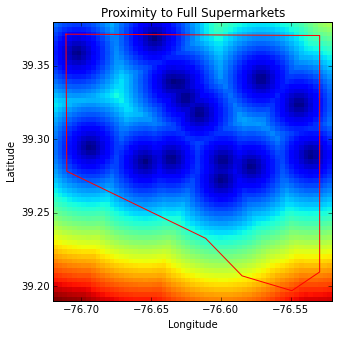

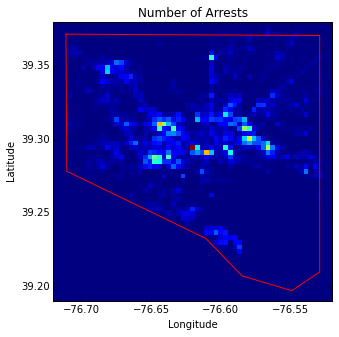

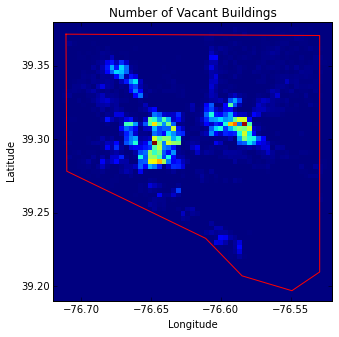

In [6]:
# plot each of the 2D heatmaps from above
mapcalc.plot_distances_to_POIs(JHU_heat)
plt.title('Proximity to JHU Homewood')
mapcalc.plot_distances_to_POIs(grocery_heat)
plt.title('Proximity to Full Supermarkets')
mapcalc.plot_distances_to_POIs(arrest_heat)
plt.title('Number of Arrests')
mapcalc.plot_distances_to_POIs(vacancy_heat)
plt.title('Number of Vacant Buildings')

In [7]:
# find the best locations by computign the product of the heatmaps above (pairwise)
optimal_locations = (1.0/JHU_heat)*(1.0/grocery_heat)*(1.0/(vacancy_heat + 1.0))*(1.0/(arrest_heat + 1.0))

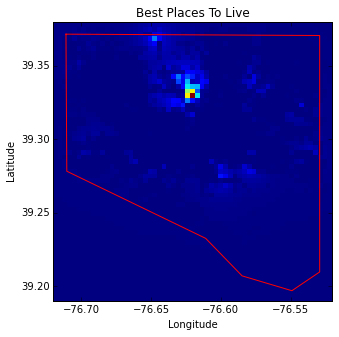

In [8]:
# plot the best locations (hotter is better)
mapcalc.plot_distances_to_POIs(optimal_locations)
plt.title('Best Places To Live')

In [9]:
lowest_val = np.amin(1.0/optimal_locations)
opt_lat, opt_lon = np.argwhere(1.0/optimal_locations == lowest_val)[0]
print 'The latitude and longitude coordinates of the best location are:\n%f, %f' % (mapcalc.y[opt_lat], mapcalc.x[opt_lon])

The latitude and longitude coordinates of the best location are:
39.328475, -76.621695


In [10]:
# Wow! That's really close to my house!